<a href="https://colab.research.google.com/github/iwmysihyhe/Travel-guide/blob/main/cw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import LinearOperator, gmres, cg


class CSRMatrix(LinearOperator):
    def __init__(self, input_matrix):
        if not isinstance(input_matrix, coo_matrix):
          input_matrix = input_matrix.tocoo()

        self.shape = input_matrix.shape
        self.dtype = input_matrix.dtype
        self.data = input_matrix.data
        self.indices = input_matrix.col
        self.indptr = np.zeros(self.shape[0] + 1, dtype=int)
        np.add.at(self.indptr, input_matrix.row + 1, 1)
        np.cumsum(self.indptr, out=self.indptr)

    def __add__(self, other):
        coo_self = coo_matrix((self.data, (self.indptr[:-1], self.indices)), shape=self.shape)
        coo_other = coo_matrix((other.data, (other.indptr[:-1], other.indices)), shape=other.shape)

        result_coo = coo_self + coo_other
        return CSRMatrix(result_coo)

    def _matvec(self, vector):
        result = np.zeros(self.shape[0], dtype=self.dtype)
        for i in range(self.shape[0]):
            result[i] = np.dot(self.data[self.indptr[i]:self.indptr[i+1]], vector[self.indices[self.indptr[i]:self.indptr[i+1]]])
        return result

In [26]:
def test_add():
    mat1 = coo_matrix(([1, 2, 3], ([0, 1, 2], [0, 1, 2])), shape=(3, 3))
    mat2 = coo_matrix(([4, 5, 6], ([0, 1, 2], [0, 1, 2])), shape=(3, 3))
    csr1 = CSRMatrix(mat1)
    csr2 = CSRMatrix(mat2)
    result = csr1 + csr2
    assert np.allclose(result.data, [5, 7, 9]), "The result is wrong."
    assert np.allclose(result.indices, [0, 1, 2]), "The result is wrong."
    assert np.allclose(result.indptr, [0, 1, 2, 3]), "The result is wrong."
    print("Pass the test.")

def test_matvec():
    mat = coo_matrix(([1, 2, 3], ([0, 1, 2], [0, 1, 2])), shape=(3, 3))
    csr = CSRMatrix(mat)
    vector = np.array([1, 1, 1])
    result = csr @ vector
    assert np.allclose(result, [1, 2, 3]), "The result is wrong."
    print("Pass the test.")

test_add()
test_matvec()



Pass the test.
Pass the test.


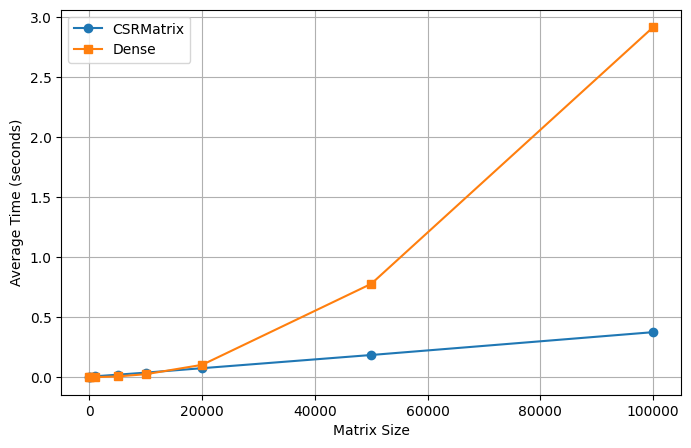

In [32]:
import timeit
import numpy as np
import matplotlib.pyplot as plt

def matvec(self, vector):
  return self._matvec(vector)

matrix_sizes = [10, 100, 1000, 5000, 10000, 20000, 50000, 100000]
csr_times = []
dense_times = []

for size in matrix_sizes:
    row = np.random.randint(0, size, size)
    col = np.random.randint(0, size, size)
    data = np.random.rand(size)
    coo = coo_matrix((data, (row, col)), shape=(size, size))
    csr = CSRMatrix(coo)
    dense = coo.toarray()
    vector = np.random.rand(size)

    csr_time = timeit.timeit(lambda: csr.matvec(vector), number=10)
    csr_times.append(csr_time / 10)

    dense_time = timeit.timeit(lambda: dense @ vector, number=10)
    dense_times.append(dense_time / 10)

plt.figure(figsize=(8, 5))
plt.plot(matrix_sizes, csr_times, label="CSRMatrix", marker="o")
plt.plot(matrix_sizes, dense_times, label="Dense", marker="s")
plt.xlabel("Matrix Size")
plt.ylabel("Average Time (seconds)")
plt.legend()
plt.grid()
plt.show()




Comment: The plot shows that the time needed to compute a dense matrix-vector product using Numpy is less than the time needed to compute a csr matrix-vector product using matvec when the matric size is small. However, when the volume of matrix size is much larger, the time needed to compute a dense matrix-vector product using Numpy is much more than that to compute csr product.

In [37]:


def solver_validation():
    size = 10
    A = np.random.rand(size, size)
    symmetric_positive_definite = A.T @ A
    coo = coo_matrix(symmetric_positive_definite)
    coo_ = coo_matrix((np.random.rand(size), (np.random.randint(0, size, size), np.random.randint(0, size, size))), shape=(size, size))
    csr = CSRMatrix(coo)
    csr_ = CSRMatrix(coo_)
    vector = np.random.rand(size)

    result_gmres, _ = gmres(csr, vector)
    result_cg, _ = cg(csr, vector)
    result_gmres_, _ = gmres(csr_, vector)
    result_cg_, _ = cg(csr_, vector)

    print("GMRES result(Positive definite matrix):", result_gmres)
    print("CG result(Positive definite matrix):", result_cg)
    print("GMRES result(random matrix):", result_gmres_)
    print("CG result(random matrix):", result_cg_)

solver_validation()

GMRES result(Positive definite matrix): [ -45.31409529  294.43222851  -16.8111659   398.47650442  104.50365445
   75.98310286 -264.69229546 -375.48855253  -20.92002673  -12.94253497]
CG result(Positive definite matrix): [ -45.31409529  294.43222852  -16.8111659   398.47650443  104.50365444
   75.98310286 -264.69229545 -375.48855252  -20.92002674  -12.94253499]
GMRES result(random matrix): [-1.13549331e+12  0.00000000e+00  1.31378755e+15  6.27757153e+13
  2.15257424e+15 -2.08935826e+13 -1.25000000e-01  1.00000000e+00
 -7.67820355e+14  1.25000000e+00]
CG result(random matrix): [ 2.54895722e+07  1.74389387e+07 -3.43232188e+07 -4.11181474e+07
  2.68253814e+07 -8.10354067e+07 -1.57589984e+07  7.33372384e+06
  2.41141211e+07 -1.15669774e+08]


Comment: When the matrix is positively defined, then the results of GMRES and CG are almost equal. When the matrix is a random metrix which is non-positively defined, the results are not equal.